In [1]:
import numpy as np

In [2]:
import random
import os
import numpy as np

crossValidationDataPaths=['NORMALIZED/NumericalData/ML/Training/RightHand','NORMALIZED/NumericalData/ML/Training/LeftHand']
testPaths=['NORMALIZED/NumericalData/ML/Test/RightHand','NORMALIZED/NumericalData/ML/Test/LeftHand']



ml_instances_paths=[]
for path in crossValidationDataPaths:
    #print(path)
    classFolders= os.listdir(path)
    for classFolder in classFolders:
        classFolder_path=f'{path}/{classFolder}'
        classTrials =os.listdir(classFolder_path)
        for trial in classTrials:
            trialPath =f'{classFolder_path}/{trial}'
            #print(trialPath)
            ml_instances_paths.append(trialPath)
            


#randomize the list
random.shuffle(ml_instances_paths)
#random.shuffle(ml_instances_paths)
#random.shuffle(ml_instances_paths)


x_shape =[]
y_shape =[]
for ml_instances_path in ml_instances_paths:
    label = ml_instances_path.split('/')
    label = label[len(label)-1].split('_')[0]
    #print(label)
    y_shape.append(int(label))
    npy =np.load(ml_instances_path)
    npy = npy*100
  
    npy_matrix=npy.reshape(-1,1629)
   
    # npy_matrix=extractPoseHand(npy)
    x_shape.append(npy_matrix)    

test_instances_paths=[]
for path in testPaths:
    #print(path)
    testFolders= os.listdir(path)
    for testFolder in testFolders:
        testFolder_path=f'{path}/{testFolder}'
        testTrials =os.listdir(testFolder_path)
        for trial in testTrials:
            trialPath =f'{testFolder_path}/{trial}'
            #print(trialPath)
            test_instances_paths.append(trialPath)


test_x_shape =[]
test_y_shape =[]
for test_instances_path in test_instances_paths:
    label = test_instances_path.split('/')
    label = label[len(label)-1].split('_')[0]
    #print(label)
    test_y_shape.append(int(label))
    npy =np.load(test_instances_path)
    npy=npy*100
    npy_matrix=npy.reshape(-1,1629)

    # npy_matrix=extractPoseHand(npy)
    
    test_x_shape.append(npy_matrix)    


In [3]:
# training the total data
from sklearn.model_selection import KFold
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import KFold
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Bidirectional, LSTM, Flatten, Dense,Input,  Dropout, BatchNormalization, GRU, Attention,Concatenate, Conv1D, Masking, Embedding
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, confusion_matrix
from tensorflow.keras.optimizers import Adam
import os

epochs = 200
batch_size = 64
NO_CLASSES = 60 #Changes according to no of class
MAX_FRMAE = 164

learning_rate = 0.00003
input_shape = (MAX_FRMAE,1629)



log_dir = os.path.join('Logs')
tb_callback = TensorBoard(log_dir=log_dir)

# print(y_shape)
#y_onehot = to_categorical(y_shape).astype(int)
label_encoder=LabelEncoder()
y_encoded =label_encoder.fit_transform(y_shape)
y_onehot =to_categorical(y_encoded,num_classes=NO_CLASSES)
print(len(y_onehot))



all_accuracies = []
x_shapeML = np.array(x_shape) #.astype(int)
x_train=x_shapeML
y_train =y_onehot

test_x_shapeML = np.array(test_x_shape) #.astype(int)
x_val=test_x_shapeML

#y_val = to_categorical(test_y_shape).astype(int)
y_encoded =label_encoder.fit_transform(test_y_shape)
y_val =to_categorical(y_encoded,num_classes=NO_CLASSES)


print('Train shape: ',x_train.shape, y_train.shape,'Test Shape: ', x_val.shape, y_val.shape)

2024-01-02 09:53:09.356213: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-02 09:53:09.479289: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-02 09:53:09.479328: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-02 09:53:09.500234: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-02 09:53:09.543946: I tensorflow/core/platform/cpu_feature_guar

[11, 54, 13, 49, 28, 8, 59, 1, 38, 8, 6, 58, 37, 23, 17, 10, 24, 45, 53, 58, 1, 36, 27, 58, 39, 54, 55, 58, 45, 20, 4, 51, 43, 47, 10, 53, 33, 1, 31, 20, 22, 9, 38, 1, 26, 17, 15, 44, 28, 46, 20, 50, 12, 38, 55, 10, 16, 12, 13, 12, 22, 50, 39, 53, 17, 3, 58, 29, 34, 33, 4, 51, 53, 40, 30, 14, 55, 9, 0, 11, 21, 59, 52, 32, 34, 11, 51, 24, 51, 29, 6, 14, 23, 22, 59, 37, 1, 20, 33, 28, 54, 31, 27, 15, 39, 7, 58, 10, 3, 27, 30, 53, 31, 9, 40, 33, 41, 14, 57, 1, 14, 45, 54, 52, 53, 29, 23, 10, 6, 43, 30, 46, 21, 15, 12, 57, 24, 7, 57, 14, 44, 52, 10, 1, 55, 53, 33, 8, 20, 36, 34, 2, 58, 37, 50, 9, 11, 35, 3, 11, 3, 15, 47, 13, 40, 56, 31, 29, 32, 19, 45, 17, 51, 10, 1, 39, 24, 54, 29, 40, 59, 20, 59, 39, 16, 36, 2, 51, 18, 16, 31, 46, 27, 4, 54, 54, 57, 9, 29, 5, 56, 27, 32, 26, 45, 45, 15, 57, 53, 13, 17, 58, 53, 13, 22, 26, 27, 3, 11, 5, 58, 50, 6, 41, 47, 41, 1, 55, 30, 48, 5, 40, 1, 14, 2, 21, 2, 19, 56, 25, 33, 12, 32, 10, 24, 43, 41, 16, 36, 59, 0, 31, 4, 8, 25, 11, 14, 48, 14, 40, 30

In [4]:


# Define and compile the model


num_folds = 10
# Train the model
kfold = KFold(n_splits=num_folds, shuffle=True)


i = 1

all_accuracies = []
test_accuracies = []
conf_matrixes = []
bestTestAccuracy=0
bestTest=0

for train, test in kfold.split(x_train, y_train):

    input = Input(shape=input_shape)
    bd1 = Bidirectional(LSTM(units=64, return_sequences=True))(input)
    # bn1 = BatchNormalization()(bd1)
    bd11 = Dropout(0.3)(bd1)

    bd2 = Bidirectional(LSTM(units=64, return_sequences=True))(input)
    # bd22 = BatchNormalization()(bd2)

    att = Attention(use_scale=True)([bd2, bd11])

    merged = Concatenate(axis=-1)([bd2, att])

    flat = Flatten()(merged)
    dense = Dense(units=64, activation='silu')(flat)
    dp2 = Dropout(0.3)(dense)
    out = Dense(NO_CLASSES, activation='softmax')(dp2)
    
    model = Model(input, out)
    optimizer = Adam(learning_rate=learning_rate)
    early_stoppage = EarlyStopping(monitor="loss",mode="auto", patience = 5,  restore_best_weights=True)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    
    print("---------------fold {} -----------".format(i))
    
    model.fit(x_train[train], y_train[train], epochs=epochs,  batch_size=batch_size, callbacks=[early_stoppage],validation_data=(x_train[test],y_train[test]))

    # Evaluate the model on the validation set
    y_val_pred = model.predict(x_train[test])
    y_val_pred_classes = np.argmax(y_val_pred, axis=1)
    y_val_true_classes = np.argmax(y_train[test], axis=1)

        # Calculate accuracy for the fold
    test_accuracy = accuracy_score(y_val_true_classes, y_val_pred_classes)
    # all_accuracies.append(test_accuracy)
    all_accuracies.append(test_accuracy)
    # average_accuracy = np.mean(all_accuracies)


    ##avg_acc = all_accuracies/epochs

    print(f'Validation Accuracy Fold {i}: {test_accuracy}')



    # Evaluate the model on the test set
    y_val_pred = model.predict(x_val)
    y_val_pred_classes = np.argmax(y_val_pred, axis=1)
    y_val_true_classes = np.argmax(y_val, axis=1)
    test_accuracy = accuracy_score(y_val_true_classes, y_val_pred_classes)
    if test_accuracy >bestTestAccuracy:
        bestTestAccuracy=test_accuracy
        bestTest=i
    print(f'Test - Accuracy: {test_accuracy}')

    test_accuracies.append(test_accuracy)

    conf_mat = confusion_matrix(y_val_true_classes,y_val_pred_classes)

    conf_matrixes.append(conf_mat)
    i += 1
    
   


average_accuracy = np.mean(all_accuracies)
print("Average  cross validation accuracy: {average_accuracy}")



average_accuracy = np.mean(test_accuracies)
print("Average test accuracy: {average_accuracy}")






2024-01-02 09:53:13.743407: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:274] failed call to cuInit: CUDA_ERROR_COMPAT_NOT_SUPPORTED_ON_DEVICE: forward compatibility was attempted on non supported HW
2024-01-02 09:53:13.743431: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:129] retrieving CUDA diagnostic information for host: DeepLearning2
2024-01-02 09:53:13.743434: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:136] hostname: DeepLearning2
2024-01-02 09:53:13.743527: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:159] libcuda reported version is: 525.147.5
2024-01-02 09:53:13.743537: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:163] kernel reported version is: 470.223.2
2024-01-02 09:53:13.743539: E external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:244] kernel version 470.223.2 does not match DSO version 525.147.5 -- cannot find working devices in this configuration


---------------fold 1 -----------
Epoch 1/200


W0000 00:00:1704167605.037582  677668 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "103" frequency: 3187 num_cores: 24 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 49152 l2_cache_size: 1310720 l3_cache_size: 31457280 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


113/113 [==============================] - ETA: 0s - loss: 3.9739 - accuracy: 0.0494

W0000 00:00:1704167627.176446  677668 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "103" frequency: 3187 num_cores: 24 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 49152 l2_cache_size: 1310720 l3_cache_size: 31457280 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


113/113 [==============================] - 25s 200ms/step - loss: 3.9739 - accuracy: 0.0494 - val_loss: 3.8029 - val_accuracy: 0.0871
Epoch 2/200
113/113 [==============================] - 22s 191ms/step - loss: 3.6658 - accuracy: 0.1106 - val_loss: 3.5045 - val_accuracy: 0.1480
Epoch 3/200
113/113 [==============================] - 22s 191ms/step - loss: 3.4420 - accuracy: 0.1570 - val_loss: 3.3334 - val_accuracy: 0.1953
Epoch 4/200
113/113 [==============================] - 21s 190ms/step - loss: 3.2796 - accuracy: 0.1892 - val_loss: 3.2103 - val_accuracy: 0.2326
Epoch 5/200
113/113 [==============================] - 21s 190ms/step - loss: 3.1682 - accuracy: 0.2130 - val_loss: 3.0285 - val_accuracy: 0.2450
Epoch 6/200
113/113 [==============================] - 21s 188ms/step - loss: 3.0308 - accuracy: 0.2322 - val_loss: 2.8911 - val_accuracy: 0.2811
Epoch 7/200
113/113 [==============================] - 22s 190ms/step - loss: 2.9461 - accuracy: 0.2535 - val_loss: 2.7677 - val_accurac

W0000 00:00:1704169666.201799  677668 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "103" frequency: 3187 num_cores: 24 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 49152 l2_cache_size: 1310720 l3_cache_size: 31457280 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


26/26 [==============================] - 1s 36ms/step
Validation Accuracy Fold 1: 0.8370646766169154
40/40 [==============================] - 1s 36ms/step
Test - Accuracy: 0.40752351097178685
---------------fold 2 -----------
Epoch 1/200


W0000 00:00:1704169680.145317  677668 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "103" frequency: 3187 num_cores: 24 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 49152 l2_cache_size: 1310720 l3_cache_size: 31457280 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


113/113 [==============================] - ETA: 0s - loss: 4.0137 - accuracy: 0.0429

W0000 00:00:1704169701.626170  677668 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "103" frequency: 3187 num_cores: 24 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 49152 l2_cache_size: 1310720 l3_cache_size: 31457280 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


113/113 [==============================] - 24s 195ms/step - loss: 4.0137 - accuracy: 0.0429 - val_loss: 3.8817 - val_accuracy: 0.0797
Epoch 2/200
113/113 [==============================] - 21s 187ms/step - loss: 3.7734 - accuracy: 0.0858 - val_loss: 3.7127 - val_accuracy: 0.1220
Epoch 3/200
113/113 [==============================] - 21s 187ms/step - loss: 3.5957 - accuracy: 0.1285 - val_loss: 3.4907 - val_accuracy: 0.1656
Epoch 4/200
113/113 [==============================] - 21s 187ms/step - loss: 3.4369 - accuracy: 0.1541 - val_loss: 3.3013 - val_accuracy: 0.1943
Epoch 5/200
113/113 [==============================] - 21s 187ms/step - loss: 3.2974 - accuracy: 0.1840 - val_loss: 3.1701 - val_accuracy: 0.2142
Epoch 6/200
113/113 [==============================] - 21s 187ms/step - loss: 3.1528 - accuracy: 0.2056 - val_loss: 3.0259 - val_accuracy: 0.2565
Epoch 7/200
113/113 [==============================] - 21s 187ms/step - loss: 3.0263 - accuracy: 0.2327 - val_loss: 2.9052 - val_accurac

W0000 00:00:1704173093.656673  677668 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "103" frequency: 3187 num_cores: 24 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 49152 l2_cache_size: 1310720 l3_cache_size: 31457280 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


26/26 [==============================] - 2s 36ms/step
Validation Accuracy Fold 2: 0.887920298879203
40/40 [==============================] - 2s 36ms/step
Test - Accuracy: 0.3620689655172414
---------------fold 3 -----------
Epoch 1/200


W0000 00:00:1704173106.189642  677668 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "103" frequency: 3187 num_cores: 24 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 49152 l2_cache_size: 1310720 l3_cache_size: 31457280 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


113/113 [==============================] - ETA: 0s - loss: 3.9407 - accuracy: 0.0584

W0000 00:00:1704173127.692748  677668 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "103" frequency: 3187 num_cores: 24 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 49152 l2_cache_size: 1310720 l3_cache_size: 31457280 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


113/113 [==============================] - 24s 196ms/step - loss: 3.9407 - accuracy: 0.0584 - val_loss: 3.7286 - val_accuracy: 0.0959
Epoch 2/200
113/113 [==============================] - 21s 188ms/step - loss: 3.6494 - accuracy: 0.1119 - val_loss: 3.4955 - val_accuracy: 0.1407
Epoch 3/200
113/113 [==============================] - 21s 188ms/step - loss: 3.4448 - accuracy: 0.1638 - val_loss: 3.3237 - val_accuracy: 0.1743
Epoch 4/200
113/113 [==============================] - 21s 187ms/step - loss: 3.2616 - accuracy: 0.2003 - val_loss: 3.1507 - val_accuracy: 0.2503
Epoch 5/200
113/113 [==============================] - 21s 187ms/step - loss: 3.1200 - accuracy: 0.2225 - val_loss: 2.9985 - val_accuracy: 0.2690
Epoch 6/200
113/113 [==============================] - 21s 188ms/step - loss: 2.9920 - accuracy: 0.2521 - val_loss: 2.7651 - val_accuracy: 0.3512
Epoch 7/200
113/113 [==============================] - 21s 188ms/step - loss: 2.8522 - accuracy: 0.2824 - val_loss: 2.6620 - val_accurac

W0000 00:00:1704175871.730585  677668 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "103" frequency: 3187 num_cores: 24 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 49152 l2_cache_size: 1310720 l3_cache_size: 31457280 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


26/26 [==============================] - 1s 36ms/step
Validation Accuracy Fold 3: 0.9090909090909091
40/40 [==============================] - 2s 37ms/step
Test - Accuracy: 0.4153605015673981
---------------fold 4 -----------
Epoch 1/200


W0000 00:00:1704175884.313652  677668 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "103" frequency: 3187 num_cores: 24 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 49152 l2_cache_size: 1310720 l3_cache_size: 31457280 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


113/113 [==============================] - ETA: 0s - loss: 3.9787 - accuracy: 0.0454

W0000 00:00:1704175906.025344  677668 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "103" frequency: 3187 num_cores: 24 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 49152 l2_cache_size: 1310720 l3_cache_size: 31457280 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


113/113 [==============================] - 24s 198ms/step - loss: 3.9787 - accuracy: 0.0454 - val_loss: 3.7739 - val_accuracy: 0.1220
Epoch 2/200
113/113 [==============================] - 21s 188ms/step - loss: 3.6973 - accuracy: 0.0975 - val_loss: 3.5021 - val_accuracy: 0.1644
Epoch 3/200
113/113 [==============================] - 21s 188ms/step - loss: 3.4555 - accuracy: 0.1444 - val_loss: 3.2606 - val_accuracy: 0.2042
Epoch 4/200
113/113 [==============================] - 21s 188ms/step - loss: 3.2737 - accuracy: 0.1793 - val_loss: 3.1132 - val_accuracy: 0.2715
Epoch 5/200
113/113 [==============================] - 21s 188ms/step - loss: 3.1564 - accuracy: 0.1969 - val_loss: 2.9593 - val_accuracy: 0.2852
Epoch 6/200
113/113 [==============================] - 21s 188ms/step - loss: 3.0390 - accuracy: 0.2252 - val_loss: 2.8467 - val_accuracy: 0.3250
Epoch 7/200
113/113 [==============================] - 21s 188ms/step - loss: 2.9173 - accuracy: 0.2525 - val_loss: 2.7627 - val_accurac

W0000 00:00:1704178374.681346  677668 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "103" frequency: 3187 num_cores: 24 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 49152 l2_cache_size: 1310720 l3_cache_size: 31457280 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


26/26 [==============================] - 1s 36ms/step
Validation Accuracy Fold 4: 0.9053549190535491
40/40 [==============================] - 2s 37ms/step
Test - Accuracy: 0.42946708463949845
---------------fold 5 -----------
Epoch 1/200


W0000 00:00:1704178387.254881  677668 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "103" frequency: 3187 num_cores: 24 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 49152 l2_cache_size: 1310720 l3_cache_size: 31457280 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


113/113 [==============================] - ETA: 0s - loss: 3.9588 - accuracy: 0.0537

W0000 00:00:1704178408.812539  677668 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "103" frequency: 3187 num_cores: 24 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 49152 l2_cache_size: 1310720 l3_cache_size: 31457280 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


113/113 [==============================] - 24s 196ms/step - loss: 3.9588 - accuracy: 0.0537 - val_loss: 3.7158 - val_accuracy: 0.0834
Epoch 2/200
113/113 [==============================] - 21s 188ms/step - loss: 3.6388 - accuracy: 0.1188 - val_loss: 3.4228 - val_accuracy: 0.2030
Epoch 3/200
113/113 [==============================] - 21s 188ms/step - loss: 3.3793 - accuracy: 0.1684 - val_loss: 3.1320 - val_accuracy: 0.2615
Epoch 4/200
113/113 [==============================] - 21s 188ms/step - loss: 3.1874 - accuracy: 0.2046 - val_loss: 2.9584 - val_accuracy: 0.3039
Epoch 5/200
113/113 [==============================] - 21s 187ms/step - loss: 3.0312 - accuracy: 0.2355 - val_loss: 2.7949 - val_accuracy: 0.3337
Epoch 6/200
113/113 [==============================] - 21s 188ms/step - loss: 2.8964 - accuracy: 0.2654 - val_loss: 2.6587 - val_accuracy: 0.3163
Epoch 7/200
113/113 [==============================] - 21s 188ms/step - loss: 2.7801 - accuracy: 0.2858 - val_loss: 2.5062 - val_accurac

W0000 00:00:1704180406.134967  677668 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "103" frequency: 3187 num_cores: 24 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 49152 l2_cache_size: 1310720 l3_cache_size: 31457280 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


26/26 [==============================] - 1s 37ms/step
Validation Accuracy Fold 5: 0.8754669987546699
40/40 [==============================] - 2s 37ms/step
Test - Accuracy: 0.3463949843260188
---------------fold 6 -----------
Epoch 1/200


W0000 00:00:1704180418.543947  677668 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "103" frequency: 3187 num_cores: 24 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 49152 l2_cache_size: 1310720 l3_cache_size: 31457280 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


113/113 [==============================] - ETA: 0s - loss: 3.9829 - accuracy: 0.0458

W0000 00:00:1704180440.112657  677668 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "103" frequency: 3187 num_cores: 24 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 49152 l2_cache_size: 1310720 l3_cache_size: 31457280 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


113/113 [==============================] - 24s 196ms/step - loss: 3.9829 - accuracy: 0.0458 - val_loss: 3.7985 - val_accuracy: 0.1083
Epoch 2/200
113/113 [==============================] - 21s 188ms/step - loss: 3.6971 - accuracy: 0.0986 - val_loss: 3.5078 - val_accuracy: 0.1432
Epoch 3/200
113/113 [==============================] - 21s 188ms/step - loss: 3.4662 - accuracy: 0.1508 - val_loss: 3.2189 - val_accuracy: 0.2366
Epoch 4/200
113/113 [==============================] - 21s 188ms/step - loss: 3.2645 - accuracy: 0.1875 - val_loss: 3.0193 - val_accuracy: 0.2603
Epoch 5/200
113/113 [==============================] - 21s 188ms/step - loss: 3.1065 - accuracy: 0.2185 - val_loss: 2.8729 - val_accuracy: 0.3163
Epoch 6/200
113/113 [==============================] - 21s 188ms/step - loss: 3.0003 - accuracy: 0.2388 - val_loss: 2.7138 - val_accuracy: 0.3138
Epoch 7/200
113/113 [==============================] - 21s 188ms/step - loss: 2.8933 - accuracy: 0.2626 - val_loss: 2.6525 - val_accurac

W0000 00:00:1704183245.851819  677668 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "103" frequency: 3187 num_cores: 24 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 49152 l2_cache_size: 1310720 l3_cache_size: 31457280 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


26/26 [==============================] - 1s 36ms/step
Validation Accuracy Fold 6: 0.9115815691158157
40/40 [==============================] - 1s 36ms/step
Test - Accuracy: 0.4561128526645768
---------------fold 7 -----------
Epoch 1/200


W0000 00:00:1704183258.294277  677668 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "103" frequency: 3187 num_cores: 24 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 49152 l2_cache_size: 1310720 l3_cache_size: 31457280 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


113/113 [==============================] - ETA: 0s - loss: 3.9591 - accuracy: 0.0502

W0000 00:00:1704183279.909585  677668 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "103" frequency: 3187 num_cores: 24 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 49152 l2_cache_size: 1310720 l3_cache_size: 31457280 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


113/113 [==============================] - 24s 197ms/step - loss: 3.9591 - accuracy: 0.0502 - val_loss: 3.7551 - val_accuracy: 0.1021
Epoch 2/200
113/113 [==============================] - 21s 189ms/step - loss: 3.6286 - accuracy: 0.1134 - val_loss: 3.3752 - val_accuracy: 0.2017
Epoch 3/200
113/113 [==============================] - 21s 188ms/step - loss: 3.3758 - accuracy: 0.1603 - val_loss: 3.1364 - val_accuracy: 0.2379
Epoch 4/200
113/113 [==============================] - 21s 188ms/step - loss: 3.1558 - accuracy: 0.2096 - val_loss: 2.9036 - val_accuracy: 0.2814
Epoch 5/200
113/113 [==============================] - 21s 188ms/step - loss: 2.9902 - accuracy: 0.2438 - val_loss: 2.7312 - val_accuracy: 0.3524
Epoch 6/200
113/113 [==============================] - 21s 188ms/step - loss: 2.8400 - accuracy: 0.2730 - val_loss: 2.5508 - val_accuracy: 0.4072
Epoch 7/200
113/113 [==============================] - 21s 188ms/step - loss: 2.7437 - accuracy: 0.2986 - val_loss: 2.4637 - val_accurac

W0000 00:00:1704186451.761193  677668 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "103" frequency: 3187 num_cores: 24 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 49152 l2_cache_size: 1310720 l3_cache_size: 31457280 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


26/26 [==============================] - 1s 36ms/step
Validation Accuracy Fold 7: 0.9277708592777086
40/40 [==============================] - 1s 36ms/step
Test - Accuracy: 0.427115987460815
---------------fold 8 -----------
Epoch 1/200


W0000 00:00:1704186464.157432  677668 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "103" frequency: 3187 num_cores: 24 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 49152 l2_cache_size: 1310720 l3_cache_size: 31457280 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


113/113 [==============================] - ETA: 0s - loss: 3.9810 - accuracy: 0.0505

W0000 00:00:1704186485.684221  677668 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "103" frequency: 3187 num_cores: 24 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 49152 l2_cache_size: 1310720 l3_cache_size: 31457280 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


113/113 [==============================] - 24s 196ms/step - loss: 3.9810 - accuracy: 0.0505 - val_loss: 3.8656 - val_accuracy: 0.0648
Epoch 2/200
113/113 [==============================] - 21s 189ms/step - loss: 3.7662 - accuracy: 0.0919 - val_loss: 3.6366 - val_accuracy: 0.1445
Epoch 3/200
113/113 [==============================] - 21s 188ms/step - loss: 3.6055 - accuracy: 0.1292 - val_loss: 3.4860 - val_accuracy: 0.1818
Epoch 4/200
113/113 [==============================] - 21s 188ms/step - loss: 3.4514 - accuracy: 0.1637 - val_loss: 3.3070 - val_accuracy: 0.2167
Epoch 5/200
113/113 [==============================] - 21s 188ms/step - loss: 3.2856 - accuracy: 0.1999 - val_loss: 3.1588 - val_accuracy: 0.2441
Epoch 6/200
113/113 [==============================] - 21s 189ms/step - loss: 3.1465 - accuracy: 0.2283 - val_loss: 3.0157 - val_accuracy: 0.2603
Epoch 7/200
113/113 [==============================] - 21s 188ms/step - loss: 3.0454 - accuracy: 0.2450 - val_loss: 2.8785 - val_accurac

W0000 00:00:1704188273.842566  677668 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "103" frequency: 3187 num_cores: 24 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 49152 l2_cache_size: 1310720 l3_cache_size: 31457280 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


26/26 [==============================] - 1s 36ms/step
Validation Accuracy Fold 8: 0.8518057285180572
40/40 [==============================] - 2s 37ms/step
Test - Accuracy: 0.3675548589341693
---------------fold 9 -----------
Epoch 1/200


W0000 00:00:1704188287.574709  677668 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "103" frequency: 3187 num_cores: 24 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 49152 l2_cache_size: 1310720 l3_cache_size: 31457280 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


113/113 [==============================] - ETA: 0s - loss: 3.9472 - accuracy: 0.0509

W0000 00:00:1704188309.143519  677668 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "103" frequency: 3187 num_cores: 24 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 49152 l2_cache_size: 1310720 l3_cache_size: 31457280 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


113/113 [==============================] - 24s 197ms/step - loss: 3.9472 - accuracy: 0.0509 - val_loss: 3.6992 - val_accuracy: 0.1133
Epoch 2/200
113/113 [==============================] - 21s 188ms/step - loss: 3.6323 - accuracy: 0.1165 - val_loss: 3.4676 - val_accuracy: 0.1619
Epoch 3/200
113/113 [==============================] - 21s 188ms/step - loss: 3.4199 - accuracy: 0.1569 - val_loss: 3.2507 - val_accuracy: 0.2217
Epoch 4/200
113/113 [==============================] - 21s 188ms/step - loss: 3.2460 - accuracy: 0.1873 - val_loss: 3.0537 - val_accuracy: 0.2428
Epoch 5/200
113/113 [==============================] - 21s 188ms/step - loss: 3.0755 - accuracy: 0.2266 - val_loss: 2.9349 - val_accuracy: 0.2528
Epoch 6/200
113/113 [==============================] - 21s 188ms/step - loss: 2.9950 - accuracy: 0.2385 - val_loss: 2.9069 - val_accuracy: 0.3039
Epoch 7/200
113/113 [==============================] - 21s 188ms/step - loss: 2.9068 - accuracy: 0.2580 - val_loss: 2.7048 - val_accurac

W0000 00:00:1704190661.755726  677668 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "103" frequency: 3187 num_cores: 24 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 49152 l2_cache_size: 1310720 l3_cache_size: 31457280 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


26/26 [==============================] - 1s 35ms/step
Validation Accuracy Fold 9: 0.8617683686176837
40/40 [==============================] - 2s 37ms/step
Test - Accuracy: 0.4051724137931034
---------------fold 10 -----------
Epoch 1/200


W0000 00:00:1704190675.108686  677668 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "103" frequency: 3187 num_cores: 24 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 49152 l2_cache_size: 1310720 l3_cache_size: 31457280 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


113/113 [==============================] - ETA: 0s - loss: 4.0046 - accuracy: 0.0390

W0000 00:00:1704190696.786444  677668 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "103" frequency: 3187 num_cores: 24 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 49152 l2_cache_size: 1310720 l3_cache_size: 31457280 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


113/113 [==============================] - 24s 197ms/step - loss: 4.0046 - accuracy: 0.0390 - val_loss: 3.8430 - val_accuracy: 0.0747
Epoch 2/200
113/113 [==============================] - 21s 189ms/step - loss: 3.7794 - accuracy: 0.0874 - val_loss: 3.6329 - val_accuracy: 0.1469
Epoch 3/200
113/113 [==============================] - 21s 189ms/step - loss: 3.6029 - accuracy: 0.1244 - val_loss: 3.4963 - val_accuracy: 0.1656
Epoch 4/200
113/113 [==============================] - 21s 189ms/step - loss: 3.4751 - accuracy: 0.1498 - val_loss: 3.2931 - val_accuracy: 0.2254
Epoch 5/200
113/113 [==============================] - 21s 188ms/step - loss: 3.3302 - accuracy: 0.1793 - val_loss: 3.1551 - val_accuracy: 0.1943
Epoch 6/200
113/113 [==============================] - 21s 188ms/step - loss: 3.2034 - accuracy: 0.2030 - val_loss: 2.9950 - val_accuracy: 0.2976
Epoch 7/200
113/113 [==============================] - 21s 190ms/step - loss: 3.1056 - accuracy: 0.2324 - val_loss: 2.8991 - val_accurac

W0000 00:00:1704193551.804994  677668 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "103" frequency: 3187 num_cores: 24 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 49152 l2_cache_size: 1310720 l3_cache_size: 31457280 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


26/26 [==============================] - 1s 37ms/step
Validation Accuracy Fold 10: 0.8542963885429639
40/40 [==============================] - 2s 37ms/step
Test - Accuracy: 0.4231974921630094
Average  cross validation accuracy: {average_accuracy}
Average test accuracy: {average_accuracy}


In [5]:
print(test_accuracies)
print(np.average(test_accuracies))
print(all_accuracies)
print(np.average(all_accuracies))

[0.40752351097178685, 0.3620689655172414, 0.4153605015673981, 0.42946708463949845, 0.3463949843260188, 0.4561128526645768, 0.427115987460815, 0.3675548589341693, 0.4051724137931034, 0.4231974921630094]
0.40399686520376166
[0.8370646766169154, 0.887920298879203, 0.9090909090909091, 0.9053549190535491, 0.8754669987546699, 0.9115815691158157, 0.9277708592777086, 0.8518057285180572, 0.8617683686176837, 0.8542963885429639]
0.8822120716467475


test accuracies:  [0.40752351097178685, 0.3620689655172414, 0.4153605015673981, 0.42946708463949845, 0.3463949843260188, 0.4561128526645768, 0.427115987460815, 0.3675548589341693, 0.4051724137931034, 0.4231974921630094] 5
validation accuracies:  [0.8370646766169154, 0.887920298879203, 0.9090909090909091, 0.9053549190535491, 0.8754669987546699, 0.9115815691158157, 0.9277708592777086, 0.8518057285180572, 0.8617683686176837, 0.8542963885429639]
60


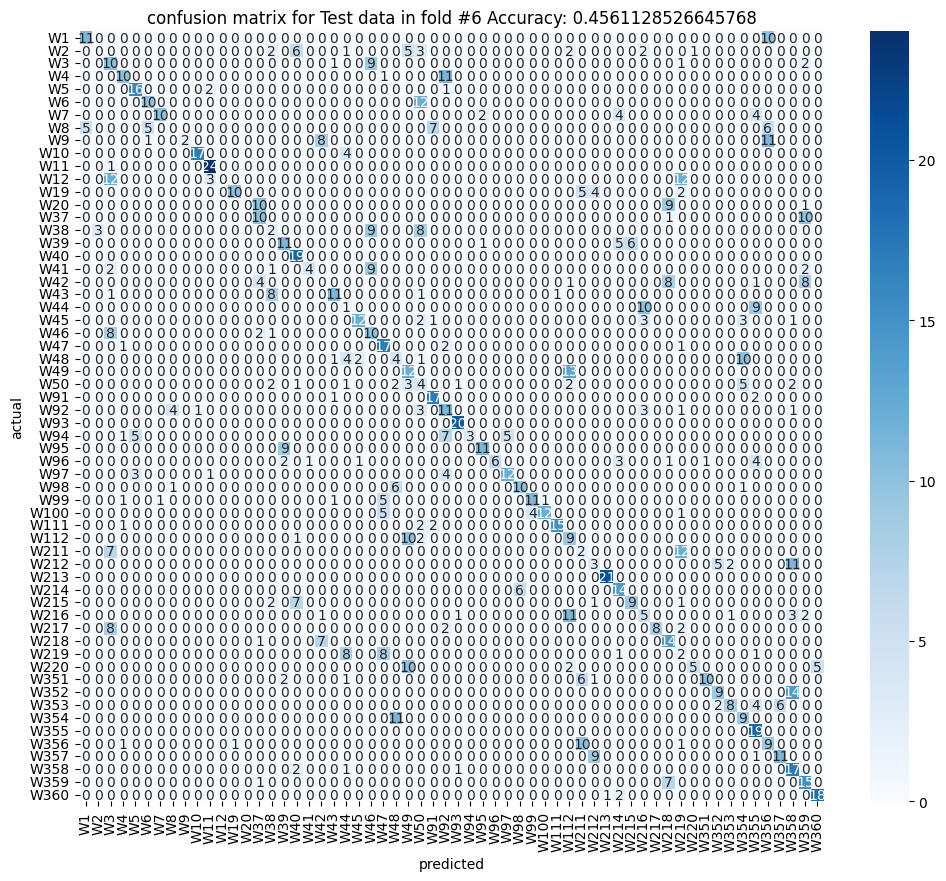

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

conf_mat= conf_matrixes[bestTest-1]
print('test accuracies: ',test_accuracies, bestTest-1)
print ('validation accuracies: ',all_accuracies)
# average_conf_mat = np.mean(conf_matrixes, axis=0)
# for conf_matrix in conf_matrixes:
#     average_conf_mat +=  conf_matrix
# y_val_true_classes,y_val_pred_classes
ylabel =['W1','W2','W3','W4','W5','W6','W7','W8','W9','W10','W11','W12','W19','W20','W37','W38','W39','W40','W41','W42','W43','W44','W45','W46','W47','W48','W49','W50','W91','W92','W93','W94','W95','W96','W97','W98','W99','W100','W111','W112','W211','W212','W213','W214','W215','W216','W217','W218','W219','W220','W351','W352','W353','W354','W355','W356','W357','W358','W359','W360']
print(len(ylabel))
# ticklabels=np.unique(y_val_true_classes)
plt.figure(figsize=(12,10))
sns.heatmap(conf_mat, annot=True, fmt='d',cmap='Blues',xticklabels=ylabel,yticklabels=ylabel)
plt.title(f'confusion matrix for Test data in fold #{bestTest} Accuracy: {test_accuracies[bestTest-1]}')
plt.xlabel('predicted')
plt.ylabel('actual')
plt.show()
